In [ ]:
from datasets import load_dataset
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from PIL import Image
import torch
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np
from torch.utils.data import Subset
import random


/home/ensta/ensta-neveu/mon_env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [24]:
class ImageLabelDataset(Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset['train'])

    def __getitem__(self, idx):
        # Récupérer l'image qui est déjà un PngImageFile
        image = self.dataset['train'][idx]['image']
        
        # Pas besoin de réouvrir l'image si elle est déjà au format PngImageFile
        if isinstance(image, Image.Image):
            img = image
        else:
            # Si ce n'est pas un PngImageFile, ouvre l'image
            img = Image.open(image)  

        label = self.dataset['train'][idx]['fake']  # Label 0 ou 1
        
        # Appliquer les transformations sur l'image
        if self.transform:
            img = self.transform(img)
        return img, label
    
    def afficher(self,idx):
        image = self.dataset['train'][idx]['image']
        
        # Pas besoin de réouvrir l'image si elle est déjà au format PngImageFile
        if isinstance(image, Image.Image):
            img = image
        else:
            # Si ce n'est pas un PngImageFile, ouvre l'image
            img = Image.open(image)  

        label = self.dataset['train'][idx]['fake']  # Label 0 ou 1
        
        # Appliquer les transformations sur l'image
        if self.transform:
            img = self.transform(img)

        # Si l'image est sous forme de tensor avec la forme (C, H, W), permuter pour (H, W, C)
        if isinstance(img, torch.Tensor):
            img = img.permute(1, 2, 0).numpy()  # Permuter et convertir en numpy pour matplotlib

        plt.imshow(img)
        plt.title(f"Label {label}")
        plt.axis('off')  # Ne pas afficher les axes
        plt.show()
    def count_classes(subset):
        """Compte le nombre d'échantillons par classe dans un torch.utils.data.dataset.Subset."""
    
        # Récupérer le dataset d'origine et les indices du subset
        full_dataset = subset.dataset  # Le dataset complet

        indices = subset.indices
        # Indices des échantillons dans le subset

        # Récupérer les labels des échantillons du subset
        labels = [full_dataset.dataset['train'][i]['fake'] for i in indices]  # Supposons que le label est à l'index 1

        # Compter le nombre d'occurrences par classe
        class_counts = Counter(labels)
    
        return class_counts

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.6331886..2.1458182].


DatasetDict({
    train: Dataset({
        features: ['id', 'image', 'fake', 'model', 'id_source', 'id_target'],
        num_rows: 9911
    })
})


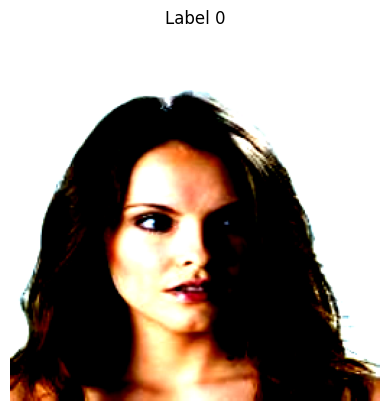

In [30]:
dataset = load_dataset("florian-morel22/deepfake-celeba")
print(dataset)


mean = [0.5042836 , 0.4235159 , 0.38155344]
std = [0.30637124 ,0.28822005, 0.28821015]


transform = transforms.Compose([
    transforms.Resize((256, 256)),  
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std) ])  

# Dataset personnalisé
train_dataset = ImageLabelDataset(dataset, transform=transform)

train_dataset.afficher(0)

In [22]:
# Fonction pour calculer la moyenne et l'écart-type
def compute_mean_std(dataset):
    mean = torch.zeros(3)
    std = torch.zeros(3)
    num_pixels = 0

    transform = transforms.ToTensor()  # Convertit en tenseur [0,1]

    for idx in range(len(dataset['train'])):
        #if dataset['train'][idx]['model'] == mode :
            image = dataset['train'][idx]['image']  # Charger l'image

            if image.mode != "RGB": #Certaine image en mode RGBA en e4s
                image = image.convert("RGB")

            image = transform(image)
            # Convertir en tenseur (C, H, W)

        
            num_pixels += image.shape[1] * image.shape[2]  # H * W
         
        
            mean += image.sum(dim=(1, 2))
            std += (image ** 2).sum(dim=(1, 2))


    mean /= num_pixels
    std = torch.sqrt(std / num_pixels - mean ** 2)

    return mean.numpy(), std.numpy()

# Exécuter la fonction
mean, std = compute_mean_std(dataset)

print("Moyenne RGB:", mean)
print("Écart-type RGB:", std)

#e4s
#Moyenne RGB: [0.4996852  0.41728333 0.37362498]
#Écart-type RGB: [0.30097532 0.28411466 0.28469956]
#REFace
#Moyenne RGB: [0.4973516  0.4177098  0.38111377]
#Écart-type RGB: [0.2999888  0.28513476 0.28656837]
#Real
#Moyenne RGB: [0.5080245 0.4274425 0.3843357]
#Écart-type RGB: [0.3100818 0.2904789 0.2898401]
#Ensemble
#Moyenne RGB: [0.5042836  0.4235159  0.38155344]
#Écart-type RGB: [0.30637124 0.28822005 0.28821015]



Moyenne RGB: [0.5042836  0.4235159  0.38155344]
Écart-type RGB: [0.30637124 0.28822005 0.28821015]


In [7]:
premiere_image=dataset['train'][6524]['image']
label=dataset['train'][6524]['fake']
print(premiere_image)
print(premiere_image.size)
print(label)
model=dataset['train'][6524]['model']
print(model)
#Le dataset est composé d'images RGB de taille 178*218 en JPEG


<PIL.PngImagePlugin.PngImageFile image mode=RGB size=178x218 at 0x78F5A3356BD0>
(178, 218)
1
REFace


In [8]:
e4s=0
REFace=0
Real=0

for i in range(len(dataset['train'])):
    if dataset['train'][i]['model']=='e4s':
        e4s+=1
    elif dataset['train'][i]['model']=='Real':
        Real+=1
    elif dataset['train'][i]['model']=='REFace':
        REFace +=1
    else:
        print(dataset['train'][i]['model'])

print(e4s)
print(REFace)
print(Real)

2000
1911
6000


In [9]:
transform = transforms.Compose([
        transforms.Resize((256, 256)),  # Redimensionner les images à une taille uniforme
        transforms.ToTensor() ])  # Convertir les images en tenseur
# Créer le Dataset personnalisé
train_dataset = ImageLabelDataset(dataset, transform=transform)
img,label=train_dataset.__getitem__(6524)
#print(img.shape) # tensor de taille 3 *256*256


In [10]:
#reface_subset (1911 images réelles et 1911 deepfake with REFace )
real_indices = [i for i in range(len(dataset['train'])) if dataset['train'][i]['model'] == 'Real']
real_indices_subset = random.sample(real_indices, 1911)
indices = [i for i in range(len(dataset['train'])) if dataset['train'][i]['model'] == 'REFace']
final_indices = real_indices_subset + indices
reface_subset = Subset(train_dataset, final_indices)
print(f"Nombre d'images du modèle REFace : {len(reface_subset)}")

Nombre d'images du modèle REFace : 3822


In [11]:
#e4s_subset (2000 images réelles et 2000 deepfake with e4s )
real_indices = [i for i in range(len(dataset['train'])) if dataset['train'][i]['model'] == 'Real']
real_indices_subset = random.sample(real_indices, 2000)
e4s_indices = [i for i in range(len(dataset['train'])) if dataset['train'][i]['model'] == 'e4s']
final_indices = real_indices_subset + e4s_indices
e4s_subset = Subset(train_dataset, final_indices)
print(f"Nombre total d'images dans le nouveau dataset : {len(e4s_subset)}")


Nombre total d'images dans le nouveau dataset : 4000


In [12]:
# Définir les tailles
train_e4s_size = int(0.8 * len(e4s_subset))   # 70% du dataset
val_e4s_size = int(0.1 * len(e4s_subset))    # 15% du dataset
test_e4s_size = len(e4s_subset) - train_e4s_size - val_e4s_size  # Le reste pour éviter les erreurs d'arrondi

# Diviser le dataset
train_e4s_subset, val_e4s_subset, test_e4s_subset = random_split(e4s_subset, [train_e4s_size, val_e4s_size, test_e4s_size])

print(f"Train: {len(train_e4s_subset)} images")
print(f"Validation: {len(val_e4s_subset)} images")
print(f"Test: {len(test_e4s_subset)} images")

# Sauvegarde du dataset sous forme d'un dictionnaire
torch.save({
    'train': train_e4s_subset,
    'val': val_e4s_subset,
    'test': test_e4s_subset
}, "e4s_dataset.pth")

print("Datasets sauvegardés avec succès dans 'e4s_dataset.pth' !")


Train: 3200 images
Validation: 400 images
Test: 400 images
Datasets sauvegardés avec succès dans 'e4s_dataset.pth' !


In [14]:
train_reface_size = int(0.8 * len(reface_subset))   # 80% pour l'entraînement
val_reface_size = int(0.1 * len(reface_subset))     # 10% pour la validation
test_reface_size = len(reface_subset) - train_reface_size - val_reface_size  # Le reste pour le test

# Diviser le dataset
train_reface_subset, val_reface_subset, test_reface_subset = random_split(reface_subset, [train_reface_size, val_reface_size, test_reface_size])

# Vérifier la répartition
print(f"Train: {len(train_reface_subset)} images")
print(f"Validation: {len(val_reface_subset)} images")
print(f"Test: {len(test_reface_subset)} images")

# Sauvegarde du dataset sous forme d'un dictionnaire
torch.save({
    'train': train_reface_subset,
    'val': val_reface_subset,
    'test': test_reface_subset
}, "reface_dataset.pth")

print("Datasets sauvegardés avec succès dans 'reface_dataset.pth' !")

Train: 3057 images
Validation: 382 images
Test: 383 images
Datasets sauvegardés avec succès dans 'reface_dataset.pth' !


In [17]:
from sklearn.model_selection import train_test_split

# Séparer les indices en fonction de la classe
real_indices = [i for i in range(len(dataset['train'])) if dataset['train'][i]['model'] == 'Real']
real_indices = real_indices_subset = random.sample(real_indices, 2000)
fake_indices = [i for i in range(len(dataset['train'])) if dataset['train'][i]['model'] == 'e4s' ]

# Diviser chaque classe en train / val / test avec train_test_split
train_real, temp_real = train_test_split(real_indices, test_size=0.2, random_state=42)
val_real, test_real = train_test_split(temp_real, test_size=0.5, random_state=42)

train_fake, temp_fake = train_test_split(fake_indices, test_size=0.2, random_state=42)
val_fake, test_fake = train_test_split(temp_fake, test_size=0.5, random_state=42)

# Fusionner les indices pour former les datasets finaux
train_indices = train_real + train_fake
val_indices = val_real + val_fake
test_indices = test_real + test_fake

# Créer les Subsets
train_e4s_subset = Subset(train_dataset, train_indices)
val_e4s_subset = Subset(train_dataset, val_indices)
test_e4s_subset = Subset(train_dataset, test_indices)

print(f"Taille du dataset d'entraînement : {len(train_e4s_subset)}")
print(f"Taille du dataset de validation : {len(val_e4s_subset)}")
print(f"Taille du dataset de test : {len(test_e4s_subset)}")

# Vérification
train_counts = ImageLabelDataset.count_classes(train_e4s_subset)
val_counts = ImageLabelDataset.count_classes(val_e4s_subset)
test_counts = ImageLabelDataset.count_classes(test_e4s_subset)

print("Distribution dans le train (E4S) :", train_counts)
print("Distribution dans la validation (E4S) :", val_counts)
print("Distribution dans le test (E4S) :", test_counts)

torch.save({
    'train': train_e4s_subset,
    'val': val_e4s_subset,
    'test': test_e4s_subset
}, "e4s_dataset.pth")

print("Datasets sauvegardés avec succès dans 'e4s_dataset.pth' !")


Taille du dataset d'entraînement : 3200
Taille du dataset de validation : 400
Taille du dataset de test : 400
Distribution dans le train (E4S) : Counter({0: 1600, 1: 1600})
Distribution dans la validation (E4S) : Counter({0: 200, 1: 200})
Distribution dans le test (E4S) : Counter({0: 200, 1: 200})
Datasets sauvegardés avec succès dans 'e4s_dataset.pth' !


In [ ]:
# Séparer les indices en fonction de la classe
real_indices = [i for i in range(len(dataset['train'])) if dataset['train'][i]['model'] == 'Real']
real_indices = random.sample(real_indices, 1911)  # Sélectionner un sous-ensemble de réels

fake_indices = [i for i in range(len(dataset['train'])) if dataset['train'][i]['model'] == 'REFace']

# Diviser chaque classe en train / val / test avec train_test_split
train_real, temp_real = train_test_split(real_indices, test_size=0.2, random_state=42)
val_real, test_real = train_test_split(temp_real, test_size=0.5, random_state=42)

train_fake, temp_fake = train_test_split(fake_indices, test_size=0.2, random_state=42)
val_fake, test_fake = train_test_split(temp_fake, test_size=0.5, random_state=42)

# Fusionner les indices pour former les datasets finaux
train_indices = train_real + train_fake
val_indices = val_real + val_fake
test_indices = test_real + test_fake

# Créer les Subsets
train_reface_subset = Subset(train_dataset, train_indices)
val_reface_subset = Subset(train_dataset, val_indices)
test_reface_subset = Subset(train_dataset, test_indices)

print(f"Taille du dataset d'entraînement (ReFace) : {len(train_reface_subset)}")
print(f"Taille du dataset de validation (ReFace) : {len(val_reface_subset)}")
print(f"Taille du dataset de test (ReFace) : {len(test_reface_subset)}")

# Vérification des distributions
train_counts = ImageLabelDataset.count_classes(train_reface_subset)
val_counts = ImageLabelDataset.count_classes(val_reface_subset)
test_counts = ImageLabelDataset.count_classes(test_reface_subset)

print("Distribution dans le train (ReFace) :", train_counts)
print("Distribution dans la validation (ReFace) :", val_counts)
print("Distribution dans le test (ReFace) :", test_counts)

torch.save({
    'train': train_reface_subset,
    'val': val_reface_subset,
    'test': test_reface_subset
}, "reface_dataset.pth")

print("Datasets sauvegardés avec succès dans 'reface_dataset.pth' !")


Taille du dataset d'entraînement (ReFace) : 3056
Taille du dataset de validation (ReFace) : 382
Taille du dataset de test (ReFace) : 384
Distribution dans le train (ReFace) : Counter({0: 1528, 1: 1528})
Distribution dans la validation (ReFace) : Counter({0: 191, 1: 191})
Distribution dans le test (ReFace) : Counter({0: 192, 1: 192})


In [18]:
a=3056+382+384
print(a)
b=1528+1528+191+191+192+192
print(b)

3822
3822
